### 単に次時刻予測をさせたモデルと、innovationの推定と同時に行ったモデルで次時刻予測の精度は変わったのか？

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+20]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
# print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
np.set_printoptions(precision=4, floatmode='fixed', suppress=True)
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path)
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
# p-Wasserstein距離の関数
import Wasserstein
path

'/home/lab/ryuichi/Documents/research/estimate-innovation/'

### ARモデルに従う時系列の作成（Fの学習と同じやつを使う）（今回はテストデータなのでseedは一番最後）

In [2]:
phi_a = [1.0, -0.5, 0.7, -0.4]
phi_b = [0]
p = len(phi_a)
q = len(phi_b)
dataSeed=2**32-1
N = 500
data = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal')
inno = tsModel.ARIMA(a=phi_a, b=phi_b, N=N, random_seed=dataSeed, randomness='normal', return_innovation=True)

### 推定に用いた（$G$の学習に使った）$\hat p$を決定

In [3]:
hat_p = 4

### 学習ずみの$F$を読み込む

In [4]:
! ls parameters/p4/

LinearGenerator.pth  LinearPredictor.pth  preLinearPredictor.pth


In [5]:
preF_paramPath = path+"checkAR/parameters/p{0}/preLinearPredictor.pth".format(hat_p)
pre_predictor = models.LinearPredictNet(input_size = hat_p+1)
pre_predictor.load_state_dict(torch.load(preF_paramPath))

F_paramPath = path+"checkAR/parameters/p{0}/LinearPredictor.pth".format(hat_p)
predictor = models.LinearPredictNet(input_size=hat_p+1)
predictor.load_state_dict(torch.load(F_paramPath))

<All keys matched successfully>

In [6]:
i=4
torch_data = torch.from_numpy(data).float()
torch.cat([torch.zeros([1,1]), torch_data[i-hat_p:i].view(1,-1)], axis=1)

tensor([[0.0000, 0.5969, 1.8244, 3.1962, 3.1633]])

In [7]:
def estimate(data, hat_p, model):
    torch_data = torch.from_numpy(data).float()
    ret = []
    for i in range(hat_p, len(data)):
        input_tensor = torch.cat([torch.zeros([1,1]), torch_data[i-hat_p:i].view(1,-1)], axis=1)
        output_tensor = model(input_tensor)
        ret.append(output_tensor.item())
    return np.array(ret)

# estimate_inno = Generate_inno(data=data, hat_p=hat_p)

In [11]:
pre_estimates = estimate(data=data, hat_p=hat_p, model=pre_predictor)
estimates = estimate(data=data, hat_p=hat_p, model=predictor)

In [9]:
predictor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 1.1525, -0.3902,  0.6458, -0.4621,  0.9577]]))])

In [10]:
pre_predictor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0040, -0.4017,  0.7122, -0.5019,  1.0023]]))])

(0, 100)

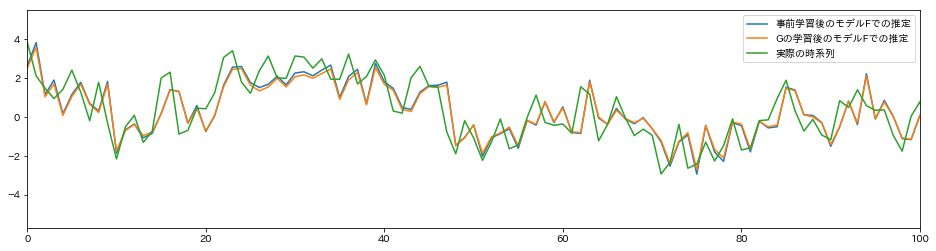

In [20]:
plt.figure(figsize=(16,4))
plt.plot(pre_estimates, label='事前学習後のモデルFでの推定')
plt.plot(estimates, label='Gの学習後のモデルFでの推定')
plt.plot(data[hat_p:], label="実際の時系列")
plt.legend()
plt.xlim([0,100])

In [23]:
((pre_estimates-data[hat_p:])**2).mean()

0.935830253128569

In [24]:
((estimates-data[hat_p:])**2).mean()

0.949024763068629

### 悪くなった...